In [1]:
## generates figures demonstrating how the time grid interpolation works

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns

import numpy as np
import pandas as pd
import scipy
from scipy.integrate import cumtrapz

import trfp
import gm2
import plotting_functions as plt2
import analysis_helper as helper
import helper_function_candidates as helper_old

matplotlib.rc('xtick', labelsize=10)     
matplotlib.rc('ytick', labelsize=10)
matplotlib.rc('axes', titlesize=10)
matplotlib.rc('axes', labelsize=10)
plt.rcParams["font.family"] = "serif"

sns.set_style('darkgrid')

Welcome to JupyROOT 6.12/04


## Show the steps of the trolley footprint replacement from helper_function_candidates.py

In [2]:
tr_interp_df = helper.root_to_pandas([3956], prefix='data1/newg2/DataProduction/Offline/ArtTFSDir/v9_20_00/FieldPlainRootOutput_', tr_run=True)
tr_moment_df = helper.calc_moment_df(tr_interp_df)

Reading event 8780/8781 99.99%  
loop done: 100%                                    
Reading event 2630/2634 99.85%   
loop done: 100%                                    
Finished calculating all moments for 4386 events.


Removing trolley image from station 10.


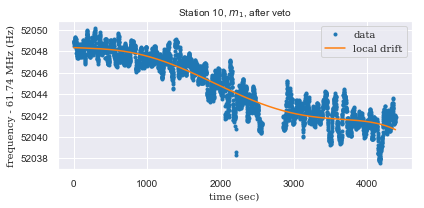

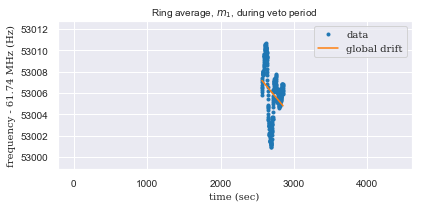

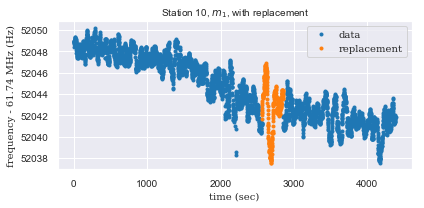

In [3]:
no_mask_df = tr_moment_df.copy()
t0 = no_mask_df.index.values[0]
no_mask_df.index -= t0
index = no_mask_df.index.values
veto_extent=25

for st in [10]:  # [range(72)]:
    print '\rRemoving trolley image from station '+str(st)+'.',

    # veto when trolley is close to station

    veto_low = (trfp.STATION_BARCODE_PHI[st]-1.5-veto_extent/2)%360
    veto_high = (trfp.STATION_BARCODE_PHI[st]-1.5+veto_extent/2)%360
    if veto_low < veto_high:
        veto_mask = (no_mask_df['tr_phi']>veto_low) & (no_mask_df['tr_phi']<veto_high)
    else:  # this happens when wrapping around 360 deg
        veto_mask = (no_mask_df['tr_phi']>veto_low) | (no_mask_df['tr_phi']<veto_high)

    for m in [0]:  # range(6):

        stm = 'st'+str(st)+',m'+str(m+1)

        # calculate local drift

        times = no_mask_df.index.values[~veto_mask]
        freqs = no_mask_df[stm][~veto_mask]

        local_drift_fit = np.polyfit(times, freqs, 5)
        local_drift = np.polyval(local_drift_fit, no_mask_df.index.values)

        # need to average other side of ring
        all_good_stations = np.arange(6,72)  # not using the inflector stations
        no_ground_loop_stations = np.array(range(6,16)+range(64,72))  # vaid for 25 deg veto

        # next need to average all good stations that are not within 3 of current station
        if st not in range(16, 23):  # note that these ranged were chosen for 25 deg veto
            averaging_stations = np.delete(all_good_stations,
                                           np.argwhere((np.abs((all_good_stations - st)%72)<=3)
                                                      | (np.abs((all_good_stations - st)%72)>=69))
                                          )
        else:
            averaging_stations = np.delete(no_ground_loop_stations,
                                           np.argwhere((np.abs((no_ground_loop_stations - st)%72)<=3)
                                                      | (np.abs((no_ground_loop_stations - st)%72)>=69))
                                          )
        avg_stms = ['st'+str(avg_st)+',m'+str(m+1) for avg_st in averaging_stations]
        replacement = no_mask_df[avg_stms].mean(axis=1)
        replacement2 = replacement.copy()

        # calculate global drift
        global_drift_fit = np.polyfit(index[veto_mask], replacement[veto_mask], 1)
        global_drift = np.polyval(global_drift_fit, index[veto_mask])
        
        fig2, ax2 = plt.subplots(1,1)
        ax2.plot(no_mask_df.index.values[~veto_mask],
                 no_mask_df[stm].values[~veto_mask], '.', color='C0', label='data')
        ax2.plot(no_mask_df.index.values, local_drift, color='C1', label='local drift')

        ax2.set_xlabel('time (sec)', fontdict={'family':'serif'})
        ax2.set_ylabel('frequency - 61.74 MHz (Hz)', fontdict={'family':'serif'})
        ax2.set_title(r'Station 10, $m_1$, after veto')
        ax2.legend(prop={'size':10, 'family':'serif'})

        fig2.set_size_inches(6,3)
        fig2.tight_layout()
        
        fig3, ax3 = plt.subplots(1,1)
        ax3.plot(no_mask_df.index.values[veto_mask], replacement.values[veto_mask], '.', color='C0', label='data')
        ax3.plot(index[veto_mask], global_drift, color='C1', label='global drift')
        ax3.set_xlim(ax2.get_xlim())
        
        y_range = (ax2.get_ylim()[1] - ax2.get_ylim()[0])/2
        y_center = (ax3.get_ylim()[0] + ax3.get_ylim()[1])/2
        ax3.set_ylim(y_center-y_range, y_center+y_range)

        ax3.set_xlabel('time (sec)', fontdict={'family':'serif'})
        ax3.set_ylabel('frequency - 61.74 MHz (Hz)', fontdict={'family':'serif'})
        ax3.set_title(r'Ring average, $m_1$, during veto period')
        ax3.legend(prop={'size':10, 'family':'serif'})
        
        fig3.set_size_inches(6,3)
        fig3.tight_layout()

        # subtract global drift from replacement
        replacement = replacement[veto_mask] - global_drift

        # add local drift
        replacement = replacement + local_drift[veto_mask]

        no_mask_df[stm][veto_mask] = replacement
        
        fig4, ax4 = plt.subplots(1,1)
        ax4.plot(no_mask_df.index.values[~veto_mask], no_mask_df[stm].values[~veto_mask], '.', color='C0', label='data')
        ax4.plot(no_mask_df.index.values[veto_mask], no_mask_df[stm].values[veto_mask], '.', color='C1', label='replacement')
        ax4.set_ylim(ax2.get_ylim())

        ax4.set_xlabel('time (sec)', fontdict={'family':'serif'})
        ax4.set_ylabel('frequency - 61.74 MHz (Hz)', fontdict={'family':'serif'})
        ax4.set_title(r'Station 10, $m_1$, with replacement')
        ax4.legend(prop={'size':10, 'family':'serif'})
        
        fig4.set_size_inches(6,3)
        fig4.tight_layout()

no_mask_df.index += t0


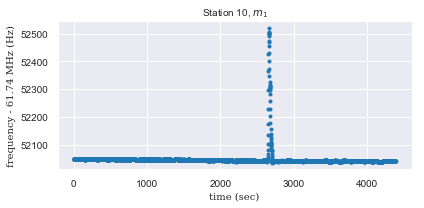

In [4]:
## show station 30 trolley footprint

fig1, ax1 = plt.subplots(1,1)

ax1.plot(tr_moment_df.index.values-tr_moment_df.index.values[0],
         tr_moment_df['st10,m1'], '.')

# ax1.set_xlim(1000,2000)

ax1.set_xlabel('time (sec)', fontdict={'family':'serif'})
ax1.set_ylabel('frequency - 61.74 MHz (Hz)', fontdict={'family':'serif'})
ax1.set_title(r'Station 10, $m_1$')

fig1.set_size_inches(6,3)
fig1.tight_layout()

In [5]:
fig1.savefig('trolley_image.png', dpi=300)
fig2.savefig('local_drift.png', dpi=300)
fig3.savefig('global_drift.png', dpi=300)
fig4.savefig('replacement.png', dpi=300)

## The station-wise averaging

In [6]:
tr_corr_df = helper_old.trolley_footprint_replacement(tr_moment_df)

Removing trolley image from station 71.             


In [7]:
tr_baseline_1, fp_baseline_1, baseline_time_1, summed_azimuth_1, summed_pts_1 = helper_old.trolley_run_station_average(tr_corr_df)

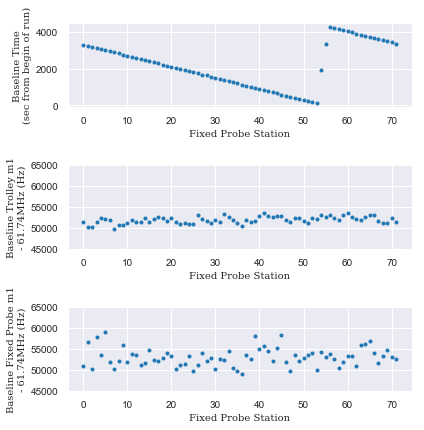

In [8]:
fig5, ax5 = plt.subplots(3,1)
ax5[0].plot(range(72), baseline_time_1[:,0]-tr_moment_df.index.values[0], '.', color='C0')
ax5[0].set_xlabel('Fixed Probe Station', fontdict={'family':'serif'})
ax5[0].set_ylabel('Baseline Time\n(sec from begin of run)', fontdict={'family':'serif'})

ax5[1].plot(range(72), tr_baseline_1[:,0], '.', color='C0')
ax5[1].set_xlabel('Fixed Probe Station', fontdict={'family':'serif'})
ax5[1].set_ylabel('Baseline Trolley m1\n- 61.74MHz (Hz)', fontdict={'family':'serif'})
ax5[1].set_ylim(45000,65000)

ax5[2].plot(range(72), fp_baseline_1[:,0], '.', color='C0')
ax5[2].set_xlabel('Fixed Probe Station', fontdict={'family':'serif'})
ax5[2].set_ylabel('Baseline Fixed Probe m1\n- 61.74MHz (Hz)', fontdict={'family':'serif'})
ax5[2].set_ylim(45000,65000)

fig5.set_size_inches(6,6)
fig5.tight_layout()

fig5.savefig('baseline_results.png', dpi=300)

## naive VTM calculation (forward only)

In [9]:
def plt_unix_time_to_CST(ax):
    ax.locator_params(axis='x', nbins=6)
    xticks = ax.get_xticks()
    ax.set_xticklabels([pd.to_datetime(tm, unit='s').tz_localize('UTC').tz_convert('US/Central').strftime('%Y-%m-%d\n %H:%M:%S %Z')
                          for tm in xticks], rotation=30, fontdict={'family':'serif'})

In [10]:
fp_interp_df = helper.root_to_pandas(range(3959,3995), prefix='data1/newg2/DataProduction/Offline/ArtTFSDir/v9_20_00/FieldPlainRootOutput_', tr_run=False)
fp_moment_df = helper.calc_moment_df(fp_interp_df)

vtm_df = helper.vtm_calc(fp_moment_df,
                         baseline_time_1, baseline_time_1+1000,
                         tr_baseline_1, tr_baseline_1,
                         fp_baseline_1, fp_baseline_1)

Reading event 154050/154052 100.00%                                                                                                                        
loop done: 100%                                    
Finished calculating all moments for 257281 events.       


In [12]:
tr_interp_df_2 = helper.root_to_pandas([3997], prefix='data1/newg2/DataProduction/Offline/ArtTFSDir/v9_20_00/FieldPlainRootOutput_', tr_run=True)
tr_moment_df_2 = helper.calc_moment_df(tr_interp_df_2)
tr_corr_df_2 = helper_old.trolley_footprint_replacement(tr_moment_df_2)
tr_baseline_2, fp_baseline_2, baseline_time_2, summed_azimuth_2, summed_pts_2 = helper_old.trolley_run_station_average(tr_corr_df_2)

Reading event 8730/8735 99.94%        
loop done: 100%                                    
Reading event 2610/2619 99.66%     
loop done: 100%                                    
Finished calculating all moments for 4363 events.
Removing trolley image from station 71.              


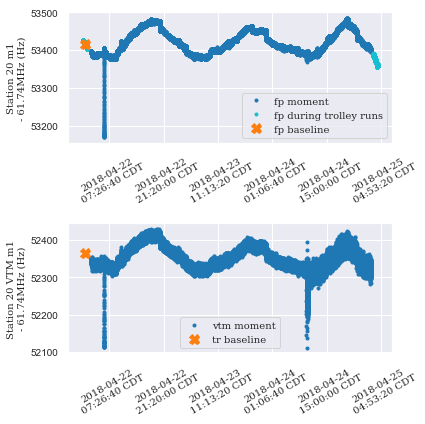

In [13]:
fig6, ax6 = plt.subplots(2,1)

ax6[0].plot(fp_moment_df.index.values, fp_moment_df['st20,m1'], '.', color='C0', label='fp moment')
ax6[0].plot(tr_corr_df.index.values, tr_corr_df['st20,m1'], '.', color='C9', label='fp during trolley runs')
ax6[0].plot(tr_corr_df_2.index.values, tr_corr_df_2['st20,m1'], '.', color='C9', label='_nolegend_')
ax6[0].plot(baseline_time_1[20,0], fp_baseline_1[20,0], 'X', color='C1', markersize=10, label='fp baseline')

ax6[1].plot(vtm_df.index.values, vtm_df['st20,m1'], '.', color='C0', label='vtm moment')
ax6[1].plot(baseline_time_1[20,0], tr_baseline_1[20,0], 'X', color='C1', markersize=10, label='tr baseline')

ax6[0].set_ylabel('Station 20 m1\n- 61.74MHz (Hz)', fontdict={'family':'serif'})
ax6[1].set_ylabel('Station 20 VTM m1\n- 61.74MHz (Hz)', fontdict={'family':'serif'})

ax6[0].legend(prop={'size':10, 'family':'serif'})
ax6[1].legend(prop={'size':10, 'family':'serif'})

plt_unix_time_to_CST(ax6[0])
ax6[1].set_xlim(ax6[0].get_xlim())
plt_unix_time_to_CST(ax6[1])

fig6.set_size_inches(6,6)
fig6.tight_layout()
fig6.savefig('vtm_naive.png', dpi=300)

## backward interploation

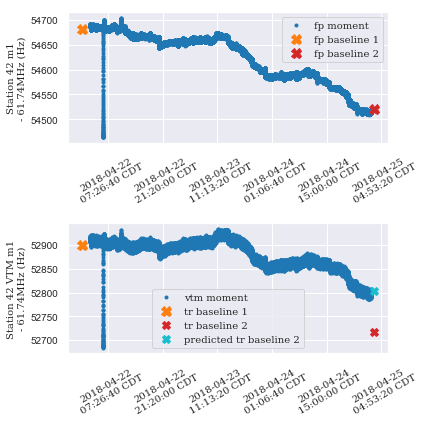

In [14]:
fig7, ax7 = plt.subplots(2,1)

ax7[0].plot(fp_moment_df.index.values, fp_moment_df['st42,m1'], '.', color='C0', label='fp moment')
ax7[0].plot(baseline_time_1[42,0], fp_baseline_1[42,0], 'X', color='C1', markersize=10, label='fp baseline 1')
ax7[0].plot(baseline_time_2[42,0], fp_baseline_2[42,0], 'X', color='C3', markersize=10, label='fp baseline 2')

ax7[1].plot(vtm_df.index.values, vtm_df['st42,m1'], '.', color='C0', label='vtm moment')
ax7[1].plot(baseline_time_1[42,0], tr_baseline_1[42,0], 'X', color='C1', markersize=10, label='tr baseline 1')
ax7[1].plot(baseline_time_2[42,0], tr_baseline_2[42,0], 'X', color='C3', markersize=8, label='tr baseline 2')

sync_offsets, delta_t = helper.sync_offset_calc(tr_corr_df, tr_corr_df_2)

ax7[1].plot(baseline_time_2[42,0], tr_baseline_2[42,0]-sync_offsets[42,0], 'X', color='C9', markersize=8, label='predicted tr baseline 2')

ax7[0].set_ylabel('Station 42 m1\n- 61.74MHz (Hz)', fontdict={'family':'serif'})
ax7[1].set_ylabel('Station 42 VTM m1\n- 61.74MHz (Hz)', fontdict={'family':'serif'})

ax7[0].legend(prop={'size':10, 'family':'serif'})
ax7[1].legend(prop={'size':10, 'family':'serif'})

plt_unix_time_to_CST(ax7[0])
ax7[1].set_xlim(ax7[0].get_xlim())
plt_unix_time_to_CST(ax7[1])

fig7.set_size_inches(6,6)
fig7.tight_layout()
fig7.savefig('glitch_demo.png', dpi=300)

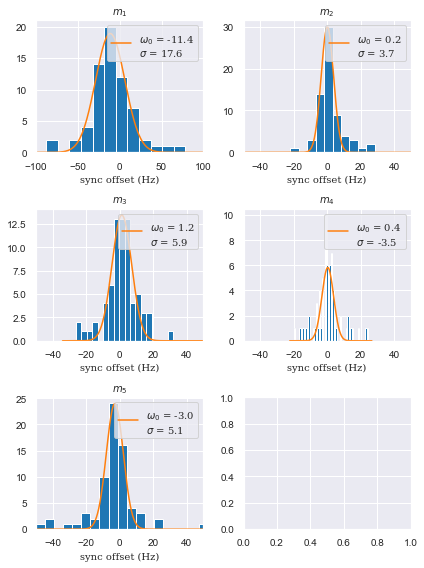

In [15]:
from scipy.optimize import curve_fit

def gaussian(x, A, x0, sigma): return A*np.exp(-(x-x0)**2/2./sigma**2)

def plt_set_labels(ax, x_label, y_label, title):
    ax.set_xlabel(x_label, fontdict={'family':'serif'})
    ax.set_ylabel(y_label, fontdict={'family':'serif'})
    ax.set_title(title, fontdict={'family':'serif'})

fig8, ax8 = plt.subplots(3,2)
for i in range(3):
    for j in range(2):
        st = 2*i+j
        if st == 5: continue
            
        plt.sca(ax8[i,j])
        hist, bins, _ = plt.hist(sync_offsets[:,st], bins=50)
        low, high = ax8[i,j].get_xlim()
                
        bins = bins[0:-1] + 0.5*(bins[1]-bins[0])
        coeffs, _ = curve_fit(gaussian, bins, hist, p0=[1., 0., 10.])
        fit = gaussian(np.arange(low, high, 0.1), coeffs[0], coeffs[1], coeffs[2])
        plt.plot(np.arange(low,high,0.1), fit, label=r'$\omega_0$ = '+str(np.round(coeffs[1],1))+'\n$\sigma$ = '+str(np.round(coeffs[2],1)))
        plt.legend(loc=1, prop={'size':10, 'family':'serif'})
        plt_set_labels(ax8[i,j], 'sync offset (Hz)', '', r'$m_'+str(st+1)+r'$')
        
        if st == 0: plt.xlim(-100,100)
        else: plt.xlim(-50,50)


fig8.set_size_inches(6,8)
fig8.tight_layout()

fig8.savefig('glitch_hist.png', dpi=300)

In [16]:
vtm_df_2 = helper.vtm_calc(fp_moment_df,
                           baseline_time_1, baseline_time_2,
                           tr_baseline_1, tr_baseline_2,
                           fp_baseline_1, fp_baseline_2)

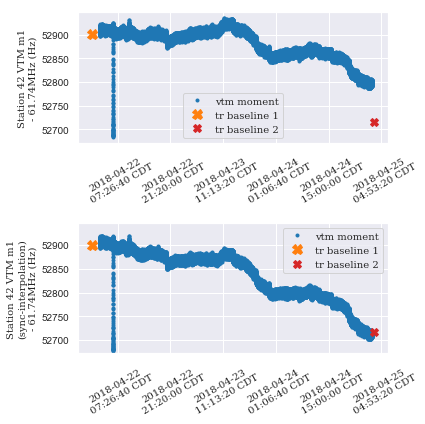

In [17]:
fig9, ax9 = plt.subplots(2,1)

ax9[0].plot(vtm_df.index.values, vtm_df['st42,m1'], '.', color='C0', label='vtm moment')
ax9[0].plot(baseline_time_1[42,0], tr_baseline_1[42,0], 'X', color='C1', markersize=10, label='tr baseline 1')
ax9[0].plot(baseline_time_2[42,0], tr_baseline_2[42,0], 'X', color='C3', markersize=8, label='tr baseline 2')

ax9[1].plot(vtm_df.index.values, vtm_df_2['st42,m1'], '.', color='C0', label='vtm moment')
ax9[1].plot(baseline_time_1[42,0], tr_baseline_1[42,0], 'X', color='C1', markersize=10, label='tr baseline 1')
ax9[1].plot(baseline_time_2[42,0], tr_baseline_2[42,0], 'X', color='C3', markersize=8, label='tr baseline 2')

ax9[0].set_ylabel('Station 42 VTM m1\n- 61.74MHz (Hz)', fontdict={'family':'serif'})
ax9[1].set_ylabel('Station 42 VTM m1\n(sync-interpolation)\n- 61.74MHz (Hz)', fontdict={'family':'serif'})

ax9[0].legend(prop={'size':10, 'family':'serif'})
ax9[1].legend(prop={'size':10, 'family':'serif'})

plt_unix_time_to_CST(ax9[0])
ax9[1].set_xlim(ax9[0].get_xlim())
plt_unix_time_to_CST(ax9[1])

ax9[1].set_ylim(ax9[0].get_ylim())

fig9.set_size_inches(6,6)
fig9.tight_layout()
fig9.savefig('backward_correction_demo.png', dpi=300)